# Pothole detection

*Jacek Piszczek 227081*

*Damodar Łepski 227122*

*__Introduction to Computer Vision PWR Course__*


In [3]:
ROAD_IMAGE_DATA_FOLDER = 'Road_Image_Data'
POTHOLE_IMAGE_DATA_FOLDER = 'Pothole_Image_Data'

### Prepare image names from folders

Pothole images are downloaded from public repository [1]. Nice road images are found in Google Graphic [2].

In [4]:
from subprocess import check_output

def get_image_list(folder_name):
    images = check_output(['ls', folder_name]).decode('utf-8').split('\n')
    return list(filter(None, images))


nice_road_images = get_image_list(ROAD_IMAGE_DATA_FOLDER)
pothole_images = get_image_list(POTHOLE_IMAGE_DATA_FOLDER)

### Scale and HOG images

This function below takes each image from given folder and:

- resize it to 640x480 resolution, to make sure each image has the same dimension. That allows to gain the same amount of features.
- calculate Histogram of Oriented Gradients with 8 orientations and group areas 8x8.
- rescale intensity of image to better show the edges.

The result of this function is an image set and feature set of given dataset.

In [13]:
import pandas as pd
from skimage.feature import hog
from skimage import data, exposure
from skimage.io import imread
from skimage.transform import resize, rotate


def scale_and_hog(folder_name, image_names, transform=lambda x: x):
    images_list = []
    features_list = []
    for img_name in image_names:
        image = imread('{}/{}'.format(folder_name, img_name))
        image = resize(image, (480, 640))
        image = transform(image)
        try:
            fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=True, multichannel=True)

            hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 5))
            images_list.append(hog_image_rescaled)
            features_list.append(fd)
        except:
            print('Error: {}'.format(img_name))
    print("{} done!".format(ROAD_IMAGE_DATA_FOLDER))
    return features_list, images_list

### Scale and HOG nice road

In [14]:
nice_fd, nice_img = scale_and_hog(ROAD_IMAGE_DATA_FOLDER, nice_road_images)

Road_Image_Data done!


### Scale and HOG nice road rotated at 180 degrees

In order to increase nice road dataset images, there are two transformations are performed. Once is a rotation (+50 images) and flip horizontally (+50 images). Total nice dataset will have 150 elements.

In [15]:
def rotate_transform(image):
    return rotate(image, 180)

nice_fd_rotated, nice_img_rotated = scale_and_hog(ROAD_IMAGE_DATA_FOLDER, nice_road_images, rotate_transform)

Road_Image_Data done!


### Scale and HOG nice road flipped horizontally

In [17]:
from numpy import fliplr

def flip_transform(image):
    return fliplr(image)

nice_fd_flipped, nice_img_flipped = scale_and_hog(ROAD_IMAGE_DATA_FOLDER, nice_road_images, flip_transform)

Road_Image_Data done!


### Scale and HOG Potholes

In [16]:
pothole_fd, pothole_img = scale_and_hog(POTHOLE_IMAGE_DATA_FOLDER, pothole_images)

Error: 5.jpg
Road_Image_Data done!


### Sample images after hog conversion

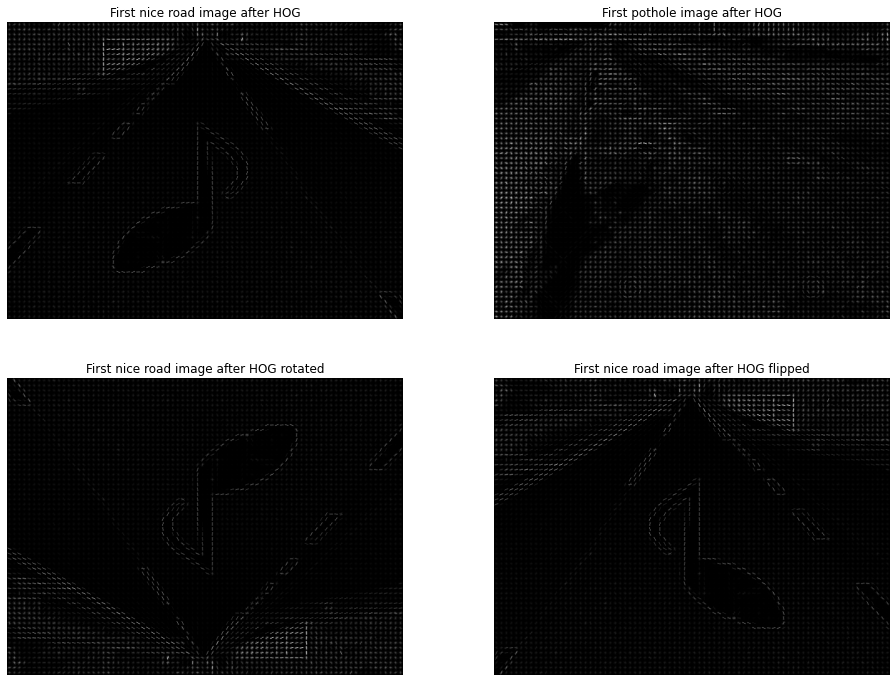

In [27]:
import matplotlib.pyplot as plt
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(nice_img[0], cmap=plt.cm.gray)
ax1.set_title('First nice road image after HOG')

ax2.axis('off')
ax2.imshow(pothole_img[0], cmap=plt.cm.gray)
ax2.set_title('First pothole image after HOG')


ax3.axis('off')
ax3.imshow(nice_img_rotated[0], cmap=plt.cm.gray)
ax3.set_title('First nice road image after HOG rotated')

ax4.axis('off')
ax4.imshow(nice_img_flipped[0], cmap=plt.cm.gray)
ax4.set_title('First nice road image after HOG flipped')

plt.show()

### Create labels and merge to one datasets

Images are preprocessed, now is time to label it. It will be binary classification:
- 0 for nice road images,
- 1 for detected image with potholes.

In [40]:
nice_labels = [0 for _ in range(len(nice_fd))]
nice_labels_rotated = [0 for _ in range(len(nice_fd_rotated))]
nice_labels_flipped = [0 for _ in range(len(nice_fd_flipped))]

pothole_labels = [1 for _ in range(len(pothole_fd))]

len_nice_labels = len(nice_labels) + len(nice_labels_rotated) + len(nice_labels_flipped)
print('Labels for nice roads: {}'.format(len_nice_labels))
print('Labels for potholes: {}'.format(len(pothole_labels)))

dataset_X = nice_fd + nice_fd_rotated + nice_fd_flipped + pothole_fd
dataset_y = nice_labels + nice_labels_rotated + nice_labels_flipped + pothole_labels

# Test image labeling
# 0-149 should be images of nice roads (0)
# Above are potholes (1)
no = 149
print('******************')
print(no, dataset_X[no], dataset_y[no])
no = 150
print(no, dataset_X[no], dataset_y[no])


Labels for nice roads: 150
Labels for potholes: 148
******************
149 [0.5698024  0.5698024  0.49605025 ... 0.23429032 0.02790453 0.        ] 0
150 [0.11041391 0.03228699 0.24211922 ... 0.43391779 0.43391779 0.41093462] 1


### Prepare data frame

Data has been moved to Pandas Dataframe and shuffled.

In [91]:
import numpy as np

dataset_X = np.array(dataset_X)
df = pd.DataFrame(dataset_X, dataset_y).sample(frac=1)

print(df)

       0         1         2         3         4         5         6      \
0   0.384671  0.384671  0.282081  0.384671  0.384671  0.282081  0.384671   
0   0.424384  0.424384  0.000000  0.424384  0.424384  0.000000  0.424384   
0   0.406824  0.406824  0.338156  0.406824  0.406824  0.338156  0.406824   
1   0.285938  0.285938  0.338875  0.285938  0.285938  0.338875  0.269819   
0   0.436391  0.436391  0.436391  0.436391  0.436391  0.436391  0.161686   
..       ...       ...       ...       ...       ...       ...       ...   
1   0.418596  0.418596  0.418596  0.418596  0.418596  0.418596  0.396288   
1   0.407020  0.407020  0.407020  0.407020  0.407020  0.407020  0.000000   
0   0.396340  0.396340  0.396340  0.396340  0.396340  0.396340  0.396340   
0   0.444470  0.444470  0.212319  0.444470  0.444470  0.212319  0.350465   
1   0.530690  0.530690  0.172324  0.530690  0.530690  0.172324  0.530690   

       7         8         9      ...     38390     38391     38392     38393  \
0   0.

### Cross validation and Classification

We got three classifiers for carry out the study.
- Support Vector Classifier capable of performing multi-class classification on a dataset[3].
- Gaussian Naive Bayes implements the Gaussian Naive Bayes algorithm for classification[3].
- Stochastic Gradiend Classifier implements a plain stochastic gradient descent learning routine which supports different loss functions and penalties for classification[3].

Dataset was divided by Stratified K-Fold cross validation, and on each fold all classifiers above was fitted and tested. Results are presented below.

In [98]:
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection
from sklearn import base
from sklearn import metrics

clfs = {
    'SVC': svm.SVC(),
    'GNB': GaussianNB(),
    'SGD': SGDClassifier(loss="hinge", penalty="l2")
}

k = 3
X = df.values
y = df.index

accuracy_scores = np.zeros((len(clfs), k))
skf = model_selection.StratifiedKFold(n_splits=k)
for fold, (train, test) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    
    for cid, clfn in enumerate(clfs):
        clf = base.clone(clfs[clfn])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        accuracy_scores[cid, fold] = metrics.accuracy_score(y_test, y_pred)

print('Done.')

Done.


In [100]:
for cid, clfn in enumerate(clfs):
    print('Accuracy for {}: {}'.format(clfn, np.mean(accuracy_scores[cid])))

Accuracy for SVC: 0.7852188552188553
Accuracy for GNB: 0.7818855218855219
Accuracy for SGD: 0.7415824915824917


### References:
    
    [1] https://www.kaggle.com/sachinpatel21/pothole-image-dataset/data
    [2] https://www.google.pl/imghp
    [3] https://scikit-learn.org/